In [132]:
import os
import cv2
import torch
import numpy as np
from torch import nn
from torchvision import models
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [97]:
def show_frame_lattice(frames, deblue=False):
    """
    Takes as an input a list of face crops, and displays it in a
    4 x N grid, where N typically is the number of videos. The basic
    idea is to be able to see images side by side for comparison
    purposes. Input images can be either in numpy (H,W,C) or PyTorch
    (C,H,W) format.
    """
    height = len(frames)//4 * 3
    width = 4 * 3
    fig=plt.figure(figsize=(width, height))
    columns = 5
    count = len(frames)
    rows = int(np.ceil(count/columns))
    for i in range(0, count):
        img = frames[i]
        if isinstance(img, np.ndarray) or isinstance(img, torch.Tensor):
            if img.max() != 255 and (img.max() > 1.0 or img.min() < 0.0):
                img = img + max(img.max(), abs(img.min()))
                img = img/img.max()
        fig.add_subplot(rows, columns, i+1)
        if isinstance(img, torch.Tensor):
            img = img.permute(1,2,0).numpy()
        if deblue:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    fig.tight_layout()
    plt.show()

In [126]:
device = ['cuda' if torch.cuda.is_available() else 'cpu']

In [133]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

In [136]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.bb = models.mobilenet_v2(pretrained=True)
        self.bb.classifier = Identity()
    
    def forward(self, x):
        return self.bb(x)

In [197]:
def image_array(files):
    arr = []
    for f in files:
        img = cv2.imread(f)
        img = cv2.resize(img, (224,224), interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        arr.append(img)        
    return arr

In [198]:
files = [f for f in os.listdir('.') if f.split('.')[-1].lower() == 'jpg']
files

['obama0.jpg', 'IMG_1399.JPG', 'IMG_1400.JPG', 'IMG_1401.JPG', 'IMG_1403.JPG']

In [148]:
fe = net()
fe.eval()

net(
  (bb): MobileNetV2(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

In [199]:
data = image_array(files)

In [200]:
data[0].shape

(224, 224, 3)

In [202]:
embeddings = [fe(torch.Tensor(x).permute(1,2,0).reshape(1,3,224,224)) for x in data]
embeddings = [x.detach().numpy() for x in embeddings]

In [210]:
x = np.zeros((len(embeddings),len(embeddings)))
for i, a in enumerate(embeddings):
    for j, b in enumerate(embeddings):
        if i == j:
            x[i][j] = np.inf
        else:
            x[i][j] = round(distance.cosine(a, b),2)
            #print(f"Distance {i} -> {j} : {x[i][j]}")

In [211]:
x

array([[ inf, 0.42, 0.39, 0.4 , 0.4 ],
       [0.42,  inf, 0.03, 0.09, 0.06],
       [0.39, 0.03,  inf, 0.1 , 0.06],
       [0.4 , 0.09, 0.1 ,  inf, 0.11],
       [0.4 , 0.06, 0.06, 0.11,  inf]])

In [216]:
closest = [None if np.argmin(x[k])+1 > 0.2 else np.argmin(x[k])+1 for k in range(x.shape[0])]
closest

[None, None, None, None, None]

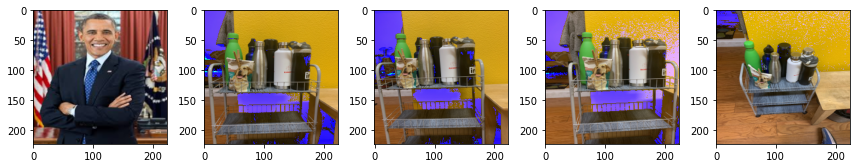

In [163]:
show_frame_lattice([a.reshape(224,224,3) for a in data])

In [209]:
embeddings

[array([[3.861672  , 0.02706482, 0.131832  , ..., 0.        , 0.        ,
         0.6277592 ]], dtype=float32),
 array([[0.21038356, 0.        , 0.76902246, ..., 0.        , 0.1392274 ,
         0.00338361]], dtype=float32),
 array([[4.5135573e-01, 3.4452940e-04, 7.7831632e-01, ..., 0.0000000e+00,
         5.0525967e-02, 1.4710679e-03]], dtype=float32),
 array([[0.68472135, 0.00406218, 0.78336567, ..., 0.        , 1.2393377 ,
         0.15850659]], dtype=float32),
 array([[0.5504194 , 0.        , 0.7746959 , ..., 0.        , 0.02382116,
         0.00135662]], dtype=float32)]

In [207]:
cv2.imread('obama0.jpg')
img = cv2.resize(img, (224,224), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
t = fe(torch.Tensor(img).permute(1,2,0).reshape(1,3,224,224))
t.detach().numpy()

array([[0.64347804, 0.        , 0.40140378, ..., 0.        , 0.0594961 ,
        0.11926488]], dtype=float32)

In [185]:
cv2.imread('IMG_1403.jpg')
img = cv2.resize(img, (224,224), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
t = fe(torch.Tensor(img).permute(1,2,0).reshape(1,3,224,224))
t.detach().numpy()

array([[0.64347804, 0.        , 0.40140378, ..., 0.        , 0.0594961 ,
        0.11926488]], dtype=float32)